Automatic Differentiation
===

This is a first attempt to create an automatic differentiation using dual numbers.
The idea comes from considering the evaluation of the function in a neighborhood close to x, so that the solution can be decomposed as follows:

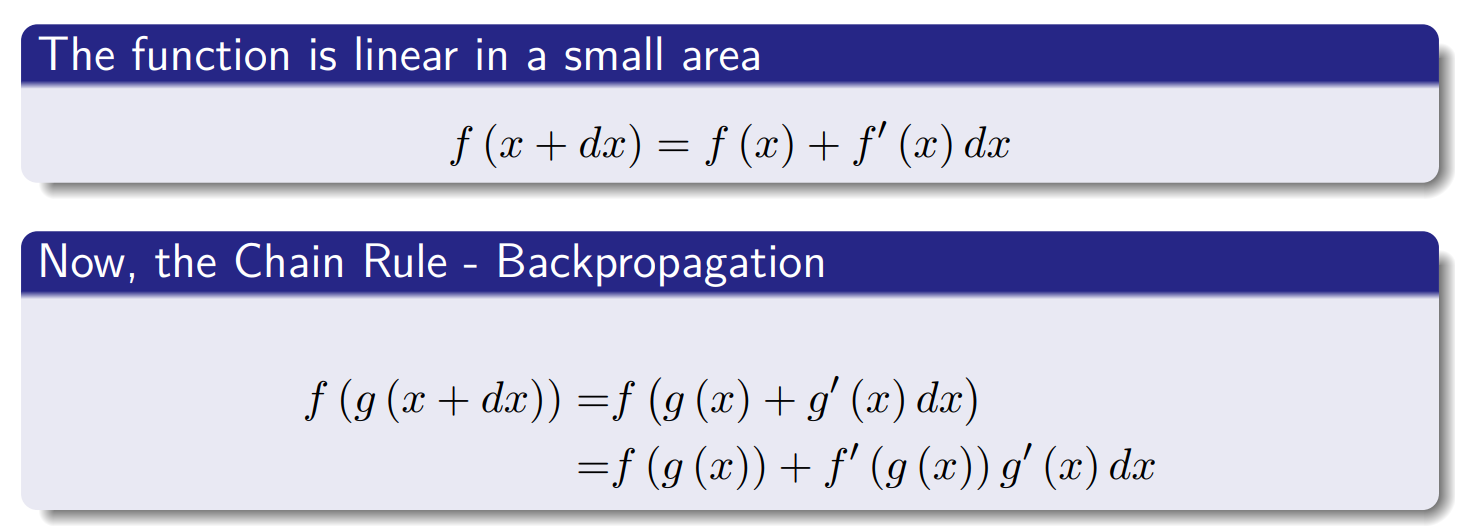

In this way it can be used in function composition to propagate the derivative, a key idea in ML

Imports

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
# Cargar el conjunto de datos MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

We define the class for the dual numbers and the operations for each of the operations or functions to be used during the forward method

In [120]:
# Definir números duales
class DualNumber:
    def __init__(self, real, dual):
        self.real = real
        self.dual = dual

def mul_dual(x,y):  # (a + bε) * (c + dε) = (ac + adε + bcε + bdε^2) = (ac + (ad + bc)ε + bdε^2), pero ε^2 = 0 => (ac + (ad + bc)ε)
    return DualNumber(x.real@y.real,x.real@y.dual+x.dual@y.real)

def add_dual(x,y):  # (a + bε) + (c + dε) = (a + c) + (b + d)ε
    return DualNumber(x.real+y.real,x.dual+y.dual)

def sigmoid(x): # σ(x) = 1 / (1 + e^(-x)), σ'(x) = σ(x) * (1 - σ(x))
    sig = 1.0 / (1.0 + torch.exp(-x.real))
    return DualNumber(sig, sig * (1.0 - sig) * x.dual)

# Cross-entropy loss
def cross_entropy_loss(predictions, targets):   # L = -Σt_i * log(p_i)
    loss = -torch.sum(targets * torch.log(predictions.real + 1e-8)) #cross entropy loss para parte real
    loss_dual = -torch.sum(targets * (1.0 / (predictions.real + 1e-8)) * predictions.dual)  #cross entropy loss para parte dual considerando log(x)'=1/x
    return DualNumber(loss, loss_dual)

def softmax_with_dual(x_dual):  
    exp_real = torch.exp(x_dual.real)
    sum_exp_real = torch.sum(exp_real, dim=1, keepdim=True)
    softmax_real = exp_real / sum_exp_real
    softmax_dual = (exp_real * (sum_exp_real - exp_real)) / (sum_exp_real * sum_exp_real) * x_dual.dual  # softmax'(x) = softmax(x) * (1 - softmax(x))
    return DualNumber(softmax_real, softmax_dual)

Define a simple MLP with automatic differentiation using dual numbers

In [121]:
class SimpleMLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = DualNumber(torch.randn(input_size, hidden_size), torch.ones(input_size, hidden_size))
        self.W2 = DualNumber(torch.randn(hidden_size, output_size), torch.ones(hidden_size, output_size))

    def forward(self, x):
        x_dual = DualNumber(x, torch.zeros_like(x))  # convertir a clase de números duales, donde el numero dual es cero
        z1 = mul_dual(x_dual,self.W1)             # multiplicar x por W1, donde W1 es un número dual con dual = 1
        a1 = sigmoid(z1)

        #es necesario propagar el dual que viene de w1 hasta el final, pero tambien es necesario inicializar el dual de w2 que luego se propagara tambien hasta el final
        #de esta forma, los duales de w1 y w2 corresponden a la derivada de la funcion de costo con respecto a w1 y w2 respectivamente
        z2_w1 = mul_dual(a1,DualNumber(self.W2.real,torch.zeros_like(self.W2.real)))    #multiplicacion considerando que el dual de w2 es cero   
        z2_w2 = mul_dual(DualNumber(a1.real,torch.zeros_like(a1.real)),self.W2)   #multiplicacion considerando que el dual a1 es cero y el dual de w2 es 1
        a2_w1=softmax_with_dual(z2_w1)
        a2_w2=softmax_with_dual(z2_w2)      

        return a2_w1,a2_w2
    

    def zero_grad(self):    #inicializar los duales de w1 y w2 en 1
        self.W1.dual=torch.ones_like(self.W1.real)
        self.W2.dual=torch.ones_like(self.W2.real)
        return self.W1,self.W2

MLP with a hidden layer

In [124]:
# Crear la MLP
input_size = 28 * 28
hidden_size = 128
output_size = 10
mlp = SimpleMLP(input_size, hidden_size, output_size)

# Entrenamiento simple usando diferenciación automática
learning_rate = 0.00000001
num_epochs = 3

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.view(-1, input_size)
        labels_onehot = torch.zeros(labels.size(0), output_size)
        labels_onehot.scatter_(1, labels.view(-1, 1), 1)

        # Forward pass
        a2_w1,a2_w2 = mlp.forward(images)
        loss_w1 = cross_entropy_loss(a2_w1, labels_onehot)
        loss_w2 = cross_entropy_loss(a2_w2, labels_onehot)

        # Actualizar parámetros
        mlp.W1.real -= learning_rate * loss_w1.dual
        mlp.W2.real -= learning_rate * loss_w2.dual

        # Limpiar duales de los pesos w
        mlp.zero_grad()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_w1.real.item()}')



Epoch [1/3], Loss: 338.3902587890625
Epoch [2/3], Loss: 374.621826171875
Epoch [3/3], Loss: 341.611083984375


this is the first attempt to implement the dual numbers to calculate the gradient of the loss function with respect to the weights, but it is not working properly yet, we 
can not reduce the loss function